## Initializing the Colab environment

In [ ]:
!wget https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip

--2024-08-26 12:58:21--  https://archive.ics.uci.edu/static/public/275/bike+sharing+dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bike+sharing+dataset.zip.1’

bike+sharing+datase     [   <=>              ] 273.43K   528KB/s    in 0.5s    

2024-08-26 12:58:22 (528 KB/s) - ‘bike+sharing+dataset.zip.1’ saved [279992]



In [ ]:
!unzip bike+sharing+dataset.zip

Archive:  bike+sharing+dataset.zip
replace Readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Importing packages

In [ ]:
%%capture
!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as scikit_LR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn import set_config
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline

# Data Engineering

## Data Collection

In [ ]:
df = pd.read_csv('hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Data Preprocessing

In [ ]:
df['day_night'] = df['hr'].apply(lambda x: 'day' if 6 <= x <= 18 else 'night')
df.drop(['instant', 'casual', 'registered'], axis=1, inplace=True)
df['dteday'] = pd.to_datetime(df.dteday)
df['holiday'] = df.holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weathersit'] = df.weathersit.astype('category')
df['workingday'] = df.workingday.astype('category')
df['mnth'] = df.mnth.astype('category')
df['yr'] = df.yr.astype('category')
df['hr'] = df.hr.astype('category')
df.drop(columns=['dteday'], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      17379 non-null  int64   
 1   yr          17379 non-null  category
 2   mnth        17379 non-null  category
 3   hr          17379 non-null  category
 4   holiday     17379 non-null  category
 5   weekday     17379 non-null  category
 6   workingday  17379 non-null  category
 7   weathersit  17379 non-null  category
 8   temp        17379 non-null  float64 
 9   atemp       17379 non-null  float64 
 10  hum         17379 non-null  float64 
 11  windspeed   17379 non-null  float64 
 12  cnt         17379 non-null  int64   
 13  day_night   17379 non-null  object  
dtypes: category(7), float64(4), int64(2), object(1)
memory usage: 1.0+ MB


## Question 1  
Create at least two new interaction features between numerical variables (e.g.,temp * hum). Justify your choice of features and explain how they might improve the model's predictive performance.

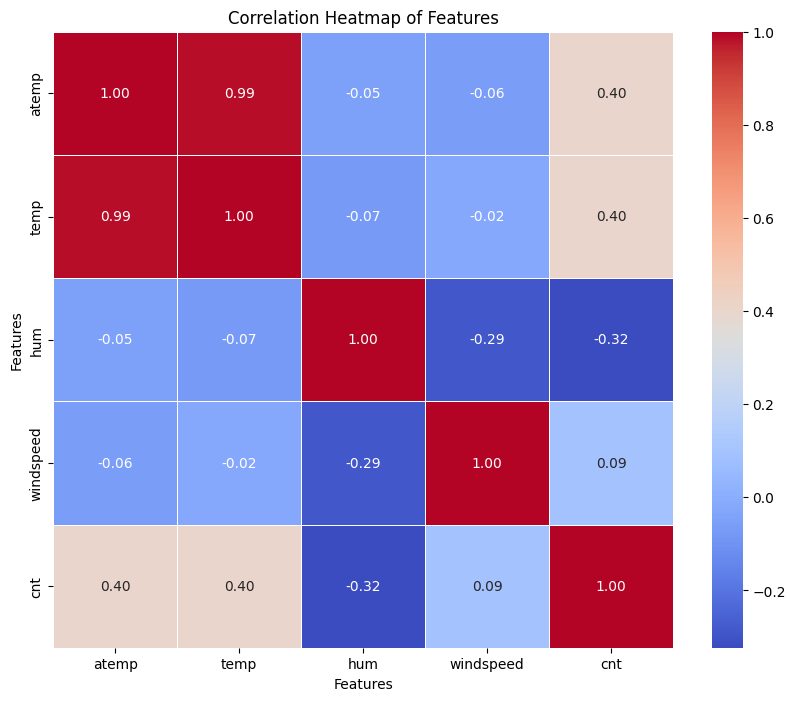

In [ ]:
def plot_heatmap(df):
  corr_matrix = df.corr()
  plt.figure(figsize=(10, 8))

  sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)

  plt.title('Correlation Heatmap of Features')
  plt.xlabel('Features')
  plt.ylabel('Features')

  plt.show()

plot_heatmap(df[['atemp', 'temp', 'hum', 'windspeed', 'cnt']])

In [ ]:
df.drop(columns=['atemp'], inplace=True)

In [ ]:
df[['temp', 'hum', 'windspeed']].isna().sum()

,0
temp,0
hum,0
windspeed,0


In [ ]:
# List of numerical features
numerical_features = ['temp', 'hum', 'windspeed']

# Create a list to store results
results = []

# Calculate correlations and store in results list
for i in range(len(numerical_features)):
    for j in range(i + 1, len(numerical_features)):
        # Calculate the new interaction feature
        new_feature = df[numerical_features[i]] * df[numerical_features[j]]

        # Calculate correlations
        corr_old_i = df[numerical_features[i]].corr(df['cnt'], method='pearson')
        corr_old_j = df[numerical_features[j]].corr(df['cnt'], method='pearson')
        # corr_old_i_new = df[numerical_features[i]].corr(new_feature, method='pearson')
        # corr_old_j_new = df[numerical_features[j]].corr(new_feature, method='pearson')
        corr_new_target = new_feature.corr(df['cnt'], method='pearson')

        # Store results
        results.append({
            'Feature_1': numerical_features[i],
            'Feature_2': numerical_features[j],
            'Corr(Feature_1, Target)': corr_old_i,
            'Corr(Feature_2, Target)': corr_old_j,
            # 'Corr(Feature_1, New_Feature)': corr_old_i_new,
            # 'Corr(Feature_2, New_Feature)': corr_old_j_new,
            'Corr(New_Feature, Target)': corr_new_target
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df

,Feature_1,Feature_2,"Corr(Feature_1, Target)","Corr(Feature_2, Target)","Corr(New_Feature, Target)"
0,temp,hum,0.404772,-0.322911,0.072283
1,temp,windspeed,0.404772,0.093234,0.306052
2,hum,windspeed,-0.322911,0.093234,-0.058614


So we take interaction features as:
1. temp with hum
2. temp with windspeed

In [ ]:
df['temp_hum'] = df['temp'] * df['hum']
df['temp_windspeed'] = df['temp'] * df['windspeed']
df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day_night,temp_hum,temp_windspeed
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,16,night,0.1944,0.0
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,40,night,0.1760,0.0
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,32,night,0.1760,0.0
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,13,night,0.1800,0.0
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,1,night,0.1800,0.0


In [ ]:
# Separating features and target variable
X = df.drop(columns=['cnt']) # Features
y = df['cnt'] # Target

In [ ]:
# Numerical features
numerical_features = ['temp', 'hum', 'windspeed', 'temp_hum', 'temp_windspeed']
numerical_pipeline = Pipeline([
('imputer', SimpleImputer(strategy='mean')), # Impute missing values with mean
('scaler', MinMaxScaler()) # Normalize using MinMaxScaler
])
# Transforming above
X[numerical_features] = numerical_pipeline.fit_transform(X[numerical_features])

In [ ]:
X.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,day_night,temp_hum,temp_windspeed
0,1,0,1,0,0,6,0,1,0.224490,0.81,0.0,night,0.312039,0.0
1,1,0,1,1,0,6,0,1,0.204082,0.80,0.0,night,0.282504,0.0
2,1,0,1,2,0,6,0,1,0.204082,0.80,0.0,night,0.282504,0.0
3,1,0,1,3,0,6,0,1,0.224490,0.75,0.0,night,0.288925,0.0
4,1,0,1,4,0,6,0,1,0.224490,0.75,0.0,night,0.288925,0.0


## Question 2
Replace the OneHotEncoder with TargetEncoder for categorical variables.
Evaluate how this change impacts the model's performance compared to one-hot
encoding.

In [ ]:
def categorical_features_transform(X, categorical_features, y=None, method='target'):
  if method == 'target':
    categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder())
    ])
    # Transforming above
    X_encoded = categorical_pipeline.fit_transform(X[categorical_features], y)
    X_encoded.columns = categorical_features
    X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)

  elif method == 'onehot':
    categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(sparse_output=False, drop='first'))
    ])
    # Transforming above
    X_encoded = categorical_pipeline.fit_transform(X[categorical_features])
    X_encoded = pd.DataFrame(X_encoded, columns=categorical_pipeline.named_steps['onehot'].get_feature_names_out(categorical_features))
    # Encoded categorical features + Numerical features
    X = pd.concat([X.drop(columns=categorical_features), X_encoded], axis=1)

  return X

In [ ]:
categorical_features = ['season', 'weathersit', 'day_night']
X_TE = categorical_features_transform(X, categorical_features, y, method='target')
X_TE.head()

,yr,mnth,hr,holiday,weekday,workingday,temp,hum,windspeed,temp_hum,temp_windspeed,season,weathersit,day_night
0,0,1,0,0,6,0,0.224490,0.81,0.0,0.312039,0.0,111.114569,204.869272,98.894138
1,0,1,1,0,6,0,0.204082,0.80,0.0,0.282504,0.0,111.114569,204.869272,98.894138
2,0,1,2,0,6,0,0.204082,0.80,0.0,0.282504,0.0,111.114569,204.869272,98.894138
3,0,1,3,0,6,0,0.224490,0.75,0.0,0.288925,0.0,111.114569,204.869272,98.894138
4,0,1,4,0,6,0,0.224490,0.75,0.0,0.288925,0.0,111.114569,204.869272,98.894138


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_TE, y, test_size=0.2, random_state=42)

## Question 3
Train LinearRegressor

a. Using the package

In [ ]:
scikit_model = scikit_LR()
scikit_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = scikit_model.predict(X_test)
mse_TE_scikit = mean_squared_error(y_test, y_pred)
r2_TE_scikit = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse_TE_scikit}')
print(f'R-squared: {r2_TE_scikit}')

Mean Squared Error: 14994.809926721106
R-squared: 0.5264609144850292


## Question 4
Integrate MLflow into your pipeline to track experiments and save the screenshot
of MLflow.

In [ ]:
final_pipeline_TE_scikit = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('target_encoder', TargetEncoder())])),
('model', scikit_LR())
])
set_config(display='diagram')

In [ ]:
final_pipeline_TE_scikit

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target_encoder', TargetEncoder())])),
                ('model', LinearRegression())])

b. Write/Train it by scratch following the steps of a linear regressor.

In [ ]:
class Linear_Regression:
    def __init__(self):
        self.w = None
        self.b = None

    def train(self, X_train, y_train):
        # Add a column of ones to X_train to account for the bias term
        A = np.column_stack((X_train, np.ones((X_train.shape[0], 1), dtype=float)))

        # Calculate beta using the normal equation
        beta = np.dot(np.linalg.inv(np.dot(A.T, A)), np.dot(A.T, y_train))

        # Extract weights and bias
        self.w = beta[:-1]  # All elements except the last one
        self.b = beta[-1]    # Last element as bias

    def test(self, X_test):
        # Prediction using the calculated weights and bias
        return np.dot(X_test, self.w) + self.b

In [ ]:
scratch_model = Linear_Regression()
scratch_model.train(X_train.to_numpy(), y_train.to_numpy())

In [ ]:
# Predictions
y_pred = scratch_model.test(X_test)
y_pred

array([364.5132466 , 114.63272871, -20.33187562, ...,  91.83458006,
       266.35965797, 132.37677181])

In [ ]:
y_pred = scratch_model.test(X_test)

mse_TE_scratch = mean_squared_error(y_test, y_pred)
r2_TE_scratch = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse_TE_scratch}')
print(f'R-squared: {r2_TE_scratch}')

Mean Squared Error: 14994.809926720685
R-squared: 0.5264609144850425


In [ ]:
final_pipeline_TE_scratch = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('target_encoder', TargetEncoder())])),
('model', Linear_Regression())
])
set_config(display='diagram')

In [ ]:
final_pipeline_TE_scratch

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('target_encoder', TargetEncoder())])),
                ('model',
                 <__main__.Linear_Regression object at 0x7effdddfbb50>)])

In [ ]:
categorical_features = ['season', 'weathersit', 'day_night']
X_onehot = categorical_features_transform(X, categorical_features, y, method='onehot')
X_onehot.head()

,yr,mnth,hr,holiday,weekday,workingday,temp,hum,windspeed,temp_hum,temp_windspeed,season_2,season_3,season_4,weathersit_2,weathersit_3,weathersit_4,day_night_night
0,0,1,0,0,6,0,0.224490,0.81,0.0,0.312039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,1,1,0,6,0,0.204082,0.80,0.0,0.282504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,1,2,0,6,0,0.204082,0.80,0.0,0.282504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,1,3,0,6,0,0.224490,0.75,0.0,0.288925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,1,4,0,6,0,0.224490,0.75,0.0,0.288925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.2, random_state=42)

In [ ]:
scikit_model = scikit_LR()
scikit_model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = scikit_model.predict(X_test)
mse_onehot_scikit = mean_squared_error(y_test, y_pred)
r2_onehot_scikit = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse_onehot_scikit}')
print(f'R-squared: {r2_onehot_scikit}')

Mean Squared Error: 14782.613643123375
R-squared: 0.5331621154055879


In [ ]:
final_pipeline_onehot_scikit = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(sparse_output=False, drop='first'))])),
('model', scikit_LR())
])
set_config(display='diagram')

In [ ]:
final_pipeline_onehot_scikit

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False))])),
                ('model', LinearRegression())])

In [ ]:
scratch_model = Linear_Regression()
scratch_model.train(X_train.to_numpy(), y_train.to_numpy())

In [ ]:
y_pred = scratch_model.test(X_test)
y_pred

array([357.54458636, 111.81637996,  -6.54157663, ...,  93.41945741,
       280.81167118, 135.65280946])

In [ ]:
y_pred = scratch_model.test(X_test)

mse_onehot_scratch = mean_squared_error(y_test, y_pred)
r2_onehot_scratch = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse_onehot_scratch}')
print(f'R-squared: {r2_onehot_scratch}')

Mean Squared Error: 14782.613643123512
R-squared: 0.5331621154055834


In [ ]:
final_pipeline_onehot_scratch = Pipeline([
('num_preprocess', numerical_pipeline),
('cat_preprocess', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(sparse_output=False, drop='first'))])),
('model', Linear_Regression())
])
set_config(display='diagram')

In [ ]:
final_pipeline_onehot_scratch

Pipeline(steps=[('num_preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer()),
                                 ('scaler', MinMaxScaler())])),
                ('cat_preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('onehot',
                                  OneHotEncoder(drop='first',
                                                sparse_output=False))])),
                ('model',
                 <__main__.Linear_Regression object at 0x7effddecccd0>)])

## Compare their performance using metrics like Mean Squared Error (MSE) and R-squared.

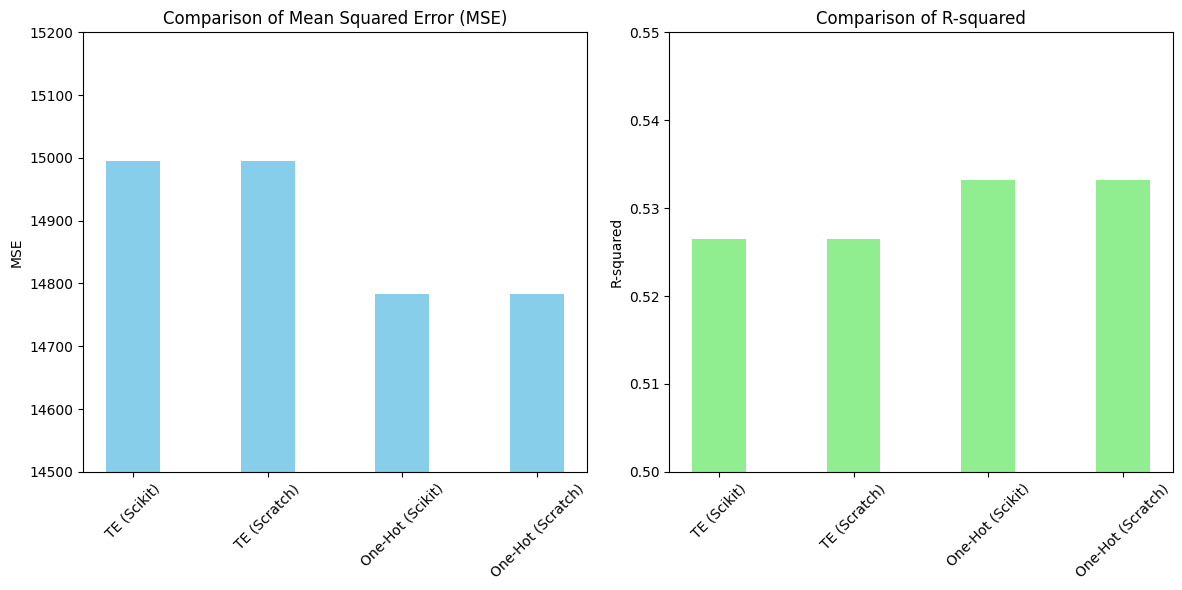

In [ ]:
labels = ['TE (Scikit)', 'TE (Scratch)', 'One-Hot (Scikit)', 'One-Hot (Scratch)']
mse_values = [mse_TE_scikit, mse_TE_scratch, mse_onehot_scikit, mse_onehot_scratch]
r2_values = [r2_TE_scikit, r2_TE_scratch, r2_onehot_scikit, r2_onehot_scratch]

width = 0.4

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(np.arange(len(labels)), mse_values, width, color='skyblue')
ax[0].set_title('Comparison of Mean Squared Error (MSE)')
ax[0].set_xticks(np.arange(len(labels)))
ax[0].set_xticklabels(labels, rotation=45)
ax[0].set_ylabel('MSE')
ax[0].set_ylim(14500, 15200)

ax[1].bar(np.arange(len(labels)), r2_values, width, color='lightgreen')
ax[1].set_title('Comparison of R-squared')
ax[1].set_xticks(np.arange(len(labels)))
ax[1].set_xticklabels(labels, rotation=45)
ax[1].set_ylabel('R-squared')
ax[1].set_ylim(0.5, 0.55)

plt.tight_layout()

plt.show()